In [6]:
import json
import os
import sys

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

from tqdm.keras import TqdmCallback

from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget

2024-08-05 21:43:39.666576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 21:43:39.900441: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 21:43:40.831553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-08-05 21:43:40.831767: W tensorflow/compiler/xla/stre

# Import Data

In [7]:
config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'

with open(config_file) as f:
    config = json.load(f)["sin"]

In [8]:
Nx = 64

In [9]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3

data_path = config["data_settings"]["data_path"]
weights_path = 'kdv_results/weights/check_vanilla'
figures_path = config["data_settings"]["figures_path"]
forcing_type = config["data_settings"]["forcing_type"]

n_psi_train = config["nn_settings"]["n_psi_train"]

kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)


kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

In [10]:
n_psi = 1 + 1 + 1 + n_psi_train

dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

pknn_epochs = config["nn_settings"]["pknn_epochs"]

In [11]:
print('dict_layer_size:', dict_layer_size)
print('K_layer_size:', K_layer_size)
print('pknn_epochs:', pknn_epochs)
print('n_psi:', n_psi)
print('Nx:', Nx)

dict_layer_size: [16, 16]
K_layer_size: [36, 36]
pknn_epochs: 500
n_psi: 6
Nx: 64


In [12]:
# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + "_"+str(Nx)+".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [13]:
print('data_x shape:', data_x.shape)
print('data_y shape:', data_y.shape)
print('data_u shape:', data_u.shape)

data_x shape: (200000, 64)
data_y shape: (200000, 64)
data_u shape: (200000, 3)


# PK-NN

In [14]:
# # PK-NN
# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)
# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.summary()

# zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

# model_pk.compile(optimizer=Adam(0.001), loss="mse")

# lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="loss",
#     factor=0.1,
#     patience=50,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=1e-12,
# )
# checkpoint_path = os.path.join(weights_path, "pk_kdv_weights_" +str(Nx) + ".h5")
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path,
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#         save_freq="epoch",
#     )

# # Define the TqdmCallback for progress bar
# tqdm_callback = TqdmCallback(verbose=1)

# callbacks = [lr_callback, checkpoint_callback, tqdm_callback]

# history_pk = model_pk.fit(
#     x=[data_x, data_y, data_u],
#     y=zeros_data_y_train,
#     validation_split=0.2,
#         epochs=pknn_epochs,
#         batch_size=200,
#         callbacks=callbacks,
#         verbose=0
#     )

# training_loss = history_pk.history['loss']
# validation_loss = history_pk.history['val_loss']
# best_epoch = validation_loss.index(min(validation_loss))
# best_loss_pk = training_loss[best_epoch]
# best_val_loss_pk = validation_loss[best_epoch]

# Vanilla

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

In [23]:
def create_vanilla_model(hidden_layers=[20], input_shape_x=(Nx,), input_shape_u=(param_dim,)):
    """
    Create a model with adjustable hidden layers.

    :param hidden_layers: List of integers, where each integer represents the number of units in a hidden layer.
    :param input_shape_x: Tuple representing the shape of input x.
    :param input_shape_u: Tuple representing the shape of input u.
    :return: Compiled Keras model.
    """
    # Define the input layers
    input_x = layers.Input(shape=input_shape_x)
    input_u = layers.Input(shape=input_shape_u)

    # Concatenate the inputs
    concatenated = layers.Concatenate()([input_x, input_u])

    # Add hidden layers based on the provided configuration
    x = concatenated
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu')(x)

    # Output layer
    output_y = layers.Dense(Nx)(x)

    # Create the model
    model = models.Model(inputs=[input_x, input_u], outputs=output_y)
    
    return model

In [24]:
# Create the model
model_vanilla = create_vanilla_model(hidden_layers=[512,512])
model_vanilla.compile(optimizer=Adam(), loss='mse')

# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 67)           0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 512)          34816       ['concatenate_2[0][0]']    

In [25]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

checkpoint_path = os.path.join(weights_path, "vanilla_kdv_weights_" +str(Nx) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        save_freq="epoch",
    )
history_vanilla = model_vanilla.fit([data_x, data_u], 
                                    data_y, 
                                    validation_split=0.2, 
                                    epochs=200, 
                                    batch_size=200, 
                                    callbacks=[lr_callback, tqdm_callback, checkpoint_callback],
                                    verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

# Tracking  Problem

In [26]:
import time

from tqdm import tqdm
tau = 10  # time horizon

## Import reference

In [27]:
# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))

## PK-NN tracking

In [28]:
# def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
#     param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
#     loss_list = []
#     y0 = y0.reshape(1, -1)
#     psi_x = dic_pk(y0)

#     for i in range(tau):
#         psi_x = model_K_u_pred_pk([param[i], psi_x])
#         obs_next = psi_x @ B
#         loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
#         loss_list.append(loss_curr)

#     ref_loss = tf.reduce_sum(loss_list)
#     param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

#     loss = ref_loss + param_loss

#     return loss


# def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

#     bounds = []
#     for i in range(tau * param_dim):
#         bounds.append((-1, 1))

#     y0_mpc_loop_list = [y0]
#     opt_control_list = []

#     results_list = []

#     t_list = []

#     param_init = (
#             np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
#         )

#     # Wrap the loop with tqdm for a progress bar
#     for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

#         t1 = time.time()
#         results = minimize(
#             loss,
#             x0=param_init,
#             args=(
#                 tau,
#                 soln_ref[current_time + 1 : current_time + 1 + tau, :],
#                 y0_mpc_loop_list[-1],
#                 B,
#                 lambda_param,
#             ),
#             bounds=bounds,
#             method='L-BFGS-B'
#         )

#         t2 = time.time()

#         results_list.append(results)

#         param = results.x.reshape(tau, param_dim)[0]
#         param_init = results.x.reshape((tau * param_dim,))
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param)

#         print("*** current time ***", current_time)
#         print("optimize time: ", t2-t1)

#         t_list.append(t2-t1)

#     print("t mean: ", np.mean(t_list))

#     current_time = current_time + 1

#     # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

#     results = minimize(
#         loss,
#         x0=param_init,
#         args=(
#             tau,
#             soln_ref[current_time + 1 : current_time + 1 + tau, :],
#             y0_mpc_loop_list[-1],
#             B,
#             lambda_param,
#         ),
#         bounds=bounds,
#     )
#     results_list.append(results)

#     param = results.x.reshape(tau, param_dim)
#     for param_curr in param:
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param_curr)

#     opt_control_list = np.asarray(opt_control_list)
#     y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

#     return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [29]:
# B_mass = dic_pk.generate_B_mass(mass_ref)
# B_momentum = dic_pk.generate_B_momentum(momentum_ref)
# ### Track mass

# # lambda_param = 0.005
# # lambda_param = 0


# pk_opt_control_momentum_5, pk_kdv_opt_momentum_soln_5, pk_results_momentum_5, pk_t_list_momentum_5 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=momentum_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_momentum,
#     loss=mpc_loss_pk,
#     lambda_param=0.005,
# )

In [30]:
# pk_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln_5), axis=-1)


## Vanilla tracking

In [31]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [32]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [33]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [34]:
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


*** current time *** 0
optimize time:  8.322528839111328


*** current time *** 1
optimize time:  1.1897485256195068


*** current time *** 2
optimize time:  3.525503158569336


*** current time *** 3
optimize time:  3.5312256813049316


*** current time *** 4
optimize time:  3.29787015914917


*** current time *** 5
optimize time:  2.9546563625335693


*** current time *** 6
optimize time:  2.9531991481781006


*** current time *** 7
optimize time:  2.97005295753479


*** current time *** 8
optimize time:  3.097526788711548


*** current time *** 9
optimize time:  3.032015800476074


*** current time *** 10
optimize time:  3.030214548110962


*** current time *** 11
optimize time:  3.054475784301758


*** current time *** 12
optimize time:  3.0906736850738525


*** current time *** 13
optimize time:  2.953139066696167


*** current time *** 14
optimize time:  2.9962048530578613


*** current time *** 15
optimize time:  2.9539248943328857


*** current time *** 16
optimize time:  2.9788765907287598


*** current time *** 17
optimize time:  2.9521188735961914


*** current time *** 18
optimize time:  3.1949732303619385


*** current time *** 19
optimize time:  3.1581263542175293


*** current time *** 20
optimize time:  3.174370050430298


*** current time *** 21
optimize time:  1.085923671722412


*** current time *** 22
optimize time:  2.9387412071228027


*** current time *** 23
optimize time:  3.114262104034424


*** current time *** 24
optimize time:  3.0244107246398926


*** current time *** 25
optimize time:  3.040661334991455


*** current time *** 26
optimize time:  3.183638572692871


*** current time *** 27
optimize time:  3.040527582168579


*** current time *** 28
optimize time:  2.9995503425598145


*** current time *** 29
optimize time:  3.0660505294799805


*** current time *** 30
optimize time:  3.175480604171753


*** current time *** 31
optimize time:  3.7998087406158447


*** current time *** 32
optimize time:  6.161654233932495


*** current time *** 33
optimize time:  3.8066062927246094


*** current time *** 34
optimize time:  4.8912060260772705


*** current time *** 35
optimize time:  3.94224214553833


*** current time *** 36
optimize time:  5.645769834518433


*** current time *** 37
optimize time:  3.6067802906036377


*** current time *** 38
optimize time:  3.5921428203582764


*** current time *** 39
optimize time:  3.2588906288146973


*** current time *** 40
optimize time:  5.067040920257568


*** current time *** 41
optimize time:  4.238001346588135


*** current time *** 42
optimize time:  4.355165004730225


*** current time *** 43
optimize time:  4.080041408538818


*** current time *** 44
optimize time:  3.6988425254821777


*** current time *** 45
optimize time:  3.6497974395751953


*** current time *** 46
optimize time:  5.386471271514893


*** current time *** 47
optimize time:  5.972206354141235


*** current time *** 48
optimize time:  5.810756683349609


*** current time *** 49
optimize time:  1.9725303649902344


*** current time *** 50
optimize time:  6.030899524688721


*** current time *** 51
optimize time:  5.101687431335449


*** current time *** 52
optimize time:  7.166685342788696


*** current time *** 53
optimize time:  5.106525897979736


*** current time *** 54
optimize time:  6.850334882736206


*** current time *** 55
optimize time:  4.188367128372192


*** current time *** 56
optimize time:  4.987344264984131


*** current time *** 57
optimize time:  7.55289363861084


*** current time *** 58
optimize time:  6.610971927642822


*** current time *** 59
optimize time:  5.4330315589904785


*** current time *** 60
optimize time:  4.5191874504089355


*** current time *** 61
optimize time:  5.640809774398804


*** current time *** 62
optimize time:  4.271849632263184


*** current time *** 63
optimize time:  7.288104772567749


*** current time *** 64
optimize time:  8.70018982887268


*** current time *** 65
optimize time:  5.55979061126709


*** current time *** 66
optimize time:  42.32074999809265


*** current time *** 67
optimize time:  27.471567392349243


*** current time *** 68
optimize time:  4.261678695678711


*** current time *** 69
optimize time:  6.1811583042144775


*** current time *** 70
optimize time:  2.343946695327759


*** current time *** 71
optimize time:  5.943042039871216


*** current time *** 72
optimize time:  4.536165714263916


*** current time *** 73
optimize time:  6.329112768173218


*** current time *** 74
optimize time:  5.470205068588257


*** current time *** 75
optimize time:  3.4226434230804443


*** current time *** 76
optimize time:  3.1851840019226074


*** current time *** 77
optimize time:  3.6314103603363037


*** current time *** 78
optimize time:  3.6118357181549072


*** current time *** 79
optimize time:  4.527282476425171


*** current time *** 80
optimize time:  5.336255788803101


*** current time *** 81
optimize time:  6.720305681228638


*** current time *** 82
optimize time:  4.441002130508423


*** current time *** 83
optimize time:  6.538378477096558


*** current time *** 84
optimize time:  6.266834259033203


*** current time *** 85
optimize time:  7.214278697967529


*** current time *** 86
optimize time:  8.085587739944458


*** current time *** 87
optimize time:  7.2760233879089355


*** current time *** 88
optimize time:  6.981251001358032


*** current time *** 89
optimize time:  5.187005043029785


*** current time *** 90
optimize time:  6.240961313247681


*** current time *** 91
optimize time:  5.408652305603027


*** current time *** 92
optimize time:  6.687807083129883


*** current time *** 93
optimize time:  7.1226935386657715


*** current time *** 94
optimize time:  6.709742069244385


*** current time *** 95
optimize time:  5.488792896270752


*** current time *** 96
optimize time:  6.686601400375366


*** current time *** 97
optimize time:  6.337305068969727


*** current time *** 98
optimize time:  6.569226026535034


*** current time *** 99
optimize time:  8.172624111175537


*** current time *** 100
optimize time:  6.436419248580933


*** current time *** 101
optimize time:  6.95632266998291


*** current time *** 102
optimize time:  6.197895288467407


*** current time *** 103
optimize time:  6.321114778518677


*** current time *** 104
optimize time:  5.1551902294158936


*** current time *** 105
optimize time:  6.288633108139038


*** current time *** 106
optimize time:  5.8433239459991455


*** current time *** 107
optimize time:  5.894919157028198


*** current time *** 108
optimize time:  6.575990200042725


*** current time *** 109
optimize time:  4.784714937210083


*** current time *** 110
optimize time:  6.261224031448364


*** current time *** 111
optimize time:  7.893467426300049


*** current time *** 112
optimize time:  6.076293468475342


*** current time *** 113
optimize time:  5.521667242050171


*** current time *** 114
optimize time:  5.549005746841431


*** current time *** 115
optimize time:  7.836502313613892


*** current time *** 116
optimize time:  8.624024629592896


*** current time *** 117
optimize time:  1.6058685779571533


*** current time *** 118
optimize time:  5.6707305908203125


*** current time *** 119
optimize time:  4.878993034362793


*** current time *** 120
optimize time:  3.640385150909424


*** current time *** 121
optimize time:  5.186718940734863


*** current time *** 122
optimize time:  8.81392788887024


*** current time *** 123
optimize time:  6.736830711364746


*** current time *** 124
optimize time:  6.5386247634887695


*** current time *** 125
optimize time:  6.392744302749634


*** current time *** 126
optimize time:  6.0902955532073975


*** current time *** 127
optimize time:  6.14829421043396


*** current time *** 128
optimize time:  2.1933395862579346


*** current time *** 129
optimize time:  7.442889928817749


*** current time *** 130
optimize time:  2.33172345161438


*** current time *** 131
optimize time:  7.48561954498291


*** current time *** 132
optimize time:  1.6741313934326172


*** current time *** 133
optimize time:  5.702275037765503


*** current time *** 134
optimize time:  9.697402477264404


*** current time *** 135
optimize time:  5.971643686294556


*** current time *** 136
optimize time:  1.701204776763916


*** current time *** 137
optimize time:  6.023907423019409


*** current time *** 138
optimize time:  2.2156002521514893


*** current time *** 139
optimize time:  5.204738140106201


*** current time *** 140
optimize time:  3.095989227294922


*** current time *** 141
optimize time:  2.3951547145843506


*** current time *** 142
optimize time:  6.580342769622803


*** current time *** 143
optimize time:  2.061004161834717


*** current time *** 144
optimize time:  7.809550523757935


*** current time *** 145
optimize time:  1.6724491119384766


*** current time *** 146
optimize time:  6.022911071777344


*** current time *** 147
optimize time:  3.0948657989501953


*** current time *** 148
optimize time:  6.971491813659668


*** current time *** 149
optimize time:  2.360973358154297


*** current time *** 150
optimize time:  6.2748541831970215


*** current time *** 151
optimize time:  1.9326128959655762


*** current time *** 152
optimize time:  4.732455492019653


*** current time *** 153
optimize time:  5.6235671043396


*** current time *** 154
optimize time:  7.268951177597046


*** current time *** 155
optimize time:  2.0557260513305664


*** current time *** 156
optimize time:  8.228185176849365


*** current time *** 157
optimize time:  3.015644073486328


*** current time *** 158
optimize time:  5.515477657318115


*** current time *** 159
optimize time:  2.168424129486084


*** current time *** 160
optimize time:  3.6788363456726074


*** current time *** 161
optimize time:  5.8523108959198


*** current time *** 162
optimize time:  1.8919274806976318


*** current time *** 163
optimize time:  5.242948055267334


*** current time *** 164
optimize time:  7.870541334152222


*** current time *** 165
optimize time:  3.745614528656006


*** current time *** 166
optimize time:  6.971619367599487


*** current time *** 167
optimize time:  1.9261066913604736


*** current time *** 168
optimize time:  1.7702105045318604


*** current time *** 169
optimize time:  6.190057277679443


*** current time *** 170
optimize time:  2.751192092895508


*** current time *** 171
optimize time:  1.4707708358764648


*** current time *** 172
optimize time:  2.596874475479126


*** current time *** 173
optimize time:  6.501452684402466


*** current time *** 174
optimize time:  2.2159714698791504


*** current time *** 175
optimize time:  1.94858980178833


*** current time *** 176
optimize time:  5.553776025772095


*** current time *** 177
optimize time:  2.000248432159424


*** current time *** 178
optimize time:  1.9357199668884277


*** current time *** 179
optimize time:  2.4374067783355713


*** current time *** 180
optimize time:  6.829695224761963


*** current time *** 181
optimize time:  3.311143159866333


*** current time *** 182
optimize time:  3.117105722427368


*** current time *** 183
optimize time:  1.6792387962341309


*** current time *** 184
optimize time:  4.966920852661133


*** current time *** 185
optimize time:  2.76737904548645


*** current time *** 186
optimize time:  1.748262643814087


*** current time *** 187
optimize time:  2.057497262954712


*** current time *** 188
optimize time:  6.4142982959747314


*** current time *** 189
optimize time:  1.9161112308502197


*** current time *** 190
optimize time:  3.585814952850342


*** current time *** 191
optimize time:  2.014277935028076


*** current time *** 192
optimize time:  2.561347723007202


*** current time *** 193
optimize time:  4.7425947189331055


*** current time *** 194
optimize time:  2.4211511611938477


*** current time *** 195
optimize time:  1.5562410354614258


*** current time *** 196
optimize time:  6.176511287689209


*** current time *** 197
optimize time:  2.667050838470459


*** current time *** 198
optimize time:  2.2889175415039062


*** current time *** 199
optimize time:  2.2921321392059326


*** current time *** 200
optimize time:  2.2360236644744873


*** current time *** 201
optimize time:  1.8852779865264893


*** current time *** 202
optimize time:  3.1356122493743896


*** current time *** 203
optimize time:  6.720900774002075


*** current time *** 204
optimize time:  2.352841377258301


*** current time *** 205
optimize time:  1.9895212650299072


*** current time *** 206
optimize time:  2.7875900268554688


*** current time *** 207
optimize time:  1.6161541938781738


*** current time *** 208
optimize time:  4.786329984664917


*** current time *** 209
optimize time:  1.8543412685394287


*** current time *** 210
optimize time:  2.8292953968048096


*** current time *** 211
optimize time:  2.5554606914520264


*** current time *** 212
optimize time:  3.322941780090332


*** current time *** 213
optimize time:  3.167740821838379


*** current time *** 214
optimize time:  1.6284854412078857


*** current time *** 215
optimize time:  4.590969800949097


*** current time *** 216
optimize time:  7.700889587402344


*** current time *** 217
optimize time:  1.9015991687774658


*** current time *** 218
optimize time:  1.9348607063293457


*** current time *** 219
optimize time:  2.514713764190674


*** current time *** 220
optimize time:  2.95784592628479


*** current time *** 221
optimize time:  2.9150500297546387


*** current time *** 222
optimize time:  1.1949641704559326


*** current time *** 223
optimize time:  1.5557043552398682


*** current time *** 224
optimize time:  8.764574766159058


*** current time *** 225
optimize time:  3.094468355178833


*** current time *** 226
optimize time:  1.6698155403137207


*** current time *** 227
optimize time:  2.085322141647339


*** current time *** 228
optimize time:  1.457798719406128


*** current time *** 229
optimize time:  1.483830451965332


*** current time *** 230
optimize time:  2.148930311203003


*** current time *** 231
optimize time:  1.3413357734680176


*** current time *** 232
optimize time:  1.7913715839385986


*** current time *** 233
optimize time:  2.3301453590393066


*** current time *** 234
optimize time:  1.460979700088501


*** current time *** 235
optimize time:  6.130169868469238


*** current time *** 236
optimize time:  4.212980508804321


*** current time *** 237
optimize time:  1.4252214431762695


*** current time *** 238
optimize time:  1.6969373226165771


*** current time *** 239
optimize time:  1.6496131420135498


*** current time *** 240
optimize time:  1.508237361907959


*** current time *** 241
optimize time:  2.313462734222412


*** current time *** 242
optimize time:  1.9232468605041504


*** current time *** 243
optimize time:  3.195862054824829


*** current time *** 244
optimize time:  3.2388455867767334


*** current time *** 245
optimize time:  2.5257623195648193


*** current time *** 246
optimize time:  3.0547447204589844


*** current time *** 247
optimize time:  7.331207275390625


*** current time *** 248
optimize time:  2.489591360092163


*** current time *** 249
optimize time:  2.4246811866760254


*** current time *** 250
optimize time:  3.1401617527008057


*** current time *** 251
optimize time:  1.896059274673462


*** current time *** 252
optimize time:  2.327770948410034


*** current time *** 253
optimize time:  2.032167434692383


*** current time *** 254
optimize time:  1.5378012657165527


*** current time *** 255
optimize time:  1.6273260116577148


*** current time *** 256
optimize time:  2.5716044902801514


*** current time *** 257
optimize time:  3.019812822341919


*** current time *** 258
optimize time:  2.158686876296997


*** current time *** 259
optimize time:  2.415640115737915


*** current time *** 260
optimize time:  1.4999985694885254


*** current time *** 261
optimize time:  2.6238174438476562


*** current time *** 262
optimize time:  2.2030928134918213


*** current time *** 263
optimize time:  2.599541425704956


*** current time *** 264
optimize time:  2.702740430831909


*** current time *** 265
optimize time:  2.912014961242676


*** current time *** 266
optimize time:  7.727283239364624


*** current time *** 267
optimize time:  1.2881464958190918


*** current time *** 268
optimize time:  2.0472357273101807


*** current time *** 269
optimize time:  2.6260826587677


*** current time *** 270
optimize time:  1.8951923847198486


*** current time *** 271
optimize time:  3.4970736503601074


*** current time *** 272
optimize time:  1.8199191093444824


*** current time *** 273
optimize time:  1.8325951099395752


*** current time *** 274
optimize time:  2.917736291885376


*** current time *** 275
optimize time:  2.376316785812378


*** current time *** 276
optimize time:  2.175720691680908


*** current time *** 277
optimize time:  3.3693175315856934


*** current time *** 278
optimize time:  1.7979857921600342


*** current time *** 279
optimize time:  2.670520305633545


*** current time *** 280
optimize time:  1.670605182647705


*** current time *** 281
optimize time:  2.3192591667175293


*** current time *** 282
optimize time:  3.5066630840301514


*** current time *** 283
optimize time:  2.2042112350463867


*** current time *** 284
optimize time:  2.8188416957855225


*** current time *** 285
optimize time:  2.127335786819458


*** current time *** 286
optimize time:  2.274721145629883


*** current time *** 287
optimize time:  1.5352532863616943


*** current time *** 288
optimize time:  2.35851788520813


*** current time *** 289
optimize time:  3.3959238529205322


*** current time *** 290
optimize time:  1.6749730110168457


*** current time *** 291
optimize time:  2.056596040725708


*** current time *** 292
optimize time:  1.7555561065673828


*** current time *** 293
optimize time:  7.321377277374268


*** current time *** 294
optimize time:  1.5915989875793457


*** current time *** 295
optimize time:  1.9927763938903809


*** current time *** 296
optimize time:  2.193685531616211


*** current time *** 297
optimize time:  2.1906142234802246


*** current time *** 298
optimize time:  1.8095598220825195


*** current time *** 299
optimize time:  2.3838369846343994


*** current time *** 300
optimize time:  1.6024770736694336


*** current time *** 301
optimize time:  2.2090327739715576


*** current time *** 302
optimize time:  2.1918275356292725


*** current time *** 303
optimize time:  3.0524420738220215


*** current time *** 304
optimize time:  2.2785186767578125


*** current time *** 305
optimize time:  2.6681087017059326


*** current time *** 306
optimize time:  2.5086679458618164


*** current time *** 307
optimize time:  3.1436049938201904


*** current time *** 308
optimize time:  2.335319995880127


*** current time *** 309
optimize time:  3.087531089782715


*** current time *** 310
optimize time:  2.270480155944824


*** current time *** 311
optimize time:  1.8015825748443604


*** current time *** 312
optimize time:  2.532679557800293


*** current time *** 313
optimize time:  3.0575664043426514


*** current time *** 314
optimize time:  2.5371360778808594


*** current time *** 315
optimize time:  2.7898311614990234


*** current time *** 316
optimize time:  2.1277987957000732


*** current time *** 317
optimize time:  2.5958361625671387


*** current time *** 318
optimize time:  2.2795190811157227


*** current time *** 319
optimize time:  1.8070096969604492


*** current time *** 320
optimize time:  1.701465129852295


*** current time *** 321
optimize time:  2.350444793701172


*** current time *** 322
optimize time:  1.781446933746338


*** current time *** 323
optimize time:  1.540189504623413


*** current time *** 324
optimize time:  1.9859445095062256


*** current time *** 325
optimize time:  1.9190518856048584


*** current time *** 326
optimize time:  1.7590992450714111


*** current time *** 327
optimize time:  2.2271101474761963


*** current time *** 328
optimize time:  3.6957225799560547


*** current time *** 329
optimize time:  3.741908550262451


*** current time *** 330
optimize time:  2.726253032684326


*** current time *** 331
optimize time:  2.5107648372650146


*** current time *** 332
optimize time:  3.5779733657836914


*** current time *** 333
optimize time:  1.5516033172607422


*** current time *** 334
optimize time:  1.6973893642425537


*** current time *** 335
optimize time:  2.2841010093688965


*** current time *** 336
optimize time:  1.6142444610595703


*** current time *** 337
optimize time:  2.540609359741211


*** current time *** 338
optimize time:  2.1490375995635986


*** current time *** 339
optimize time:  2.2433197498321533


*** current time *** 340
optimize time:  3.594747304916382


*** current time *** 341
optimize time:  1.5786125659942627


*** current time *** 342
optimize time:  2.97514009475708


*** current time *** 343
optimize time:  2.2621967792510986


*** current time *** 344
optimize time:  2.0467898845672607


*** current time *** 345
optimize time:  2.8837878704071045


*** current time *** 346
optimize time:  2.329176425933838


*** current time *** 347
optimize time:  2.1005632877349854


*** current time *** 348
optimize time:  3.3642842769622803


*** current time *** 349
optimize time:  1.7898120880126953


*** current time *** 350
optimize time:  1.3412342071533203


*** current time *** 351
optimize time:  2.184329032897949


*** current time *** 352
optimize time:  2.4185266494750977


*** current time *** 353
optimize time:  2.082068920135498


*** current time *** 354
optimize time:  1.6496334075927734


*** current time *** 355
optimize time:  2.6781139373779297


*** current time *** 356
optimize time:  2.0185372829437256


*** current time *** 357
optimize time:  2.9722883701324463


*** current time *** 358
optimize time:  1.6857736110687256


*** current time *** 359
optimize time:  2.9102816581726074


*** current time *** 360
optimize time:  1.539668321609497


*** current time *** 361
optimize time:  2.932987928390503


*** current time *** 362
optimize time:  3.062337875366211


*** current time *** 363
optimize time:  2.638901710510254


*** current time *** 364
optimize time:  2.080801248550415


*** current time *** 365
optimize time:  2.3994643688201904


*** current time *** 366
optimize time:  2.930539608001709


*** current time *** 367
optimize time:  1.4479913711547852


*** current time *** 368
optimize time:  3.026195526123047


*** current time *** 369
optimize time:  1.9560461044311523


*** current time *** 370
optimize time:  1.7480096817016602


*** current time *** 371
optimize time:  1.618718147277832


*** current time *** 372
optimize time:  2.2410199642181396


*** current time *** 373
optimize time:  1.8958547115325928


*** current time *** 374
optimize time:  1.250199556350708


*** current time *** 375
optimize time:  1.6161751747131348


*** current time *** 376
optimize time:  1.695666790008545


*** current time *** 377
optimize time:  2.403118371963501


*** current time *** 378
optimize time:  4.084197521209717


*** current time *** 379
optimize time:  2.1148693561553955


*** current time *** 380
optimize time:  1.6582391262054443


*** current time *** 381
optimize time:  2.2160584926605225


*** current time *** 382
optimize time:  6.174032211303711


*** current time *** 383
optimize time:  2.024179220199585


*** current time *** 384
optimize time:  1.152608871459961


*** current time *** 385
optimize time:  1.8504106998443604


*** current time *** 386
optimize time:  1.9449841976165771


*** current time *** 387
optimize time:  2.6969897747039795


*** current time *** 388
optimize time:  1.9004178047180176


*** current time *** 389
optimize time:  1.8138835430145264


*** current time *** 390
optimize time:  2.610966444015503


*** current time *** 391
optimize time:  2.909200668334961


*** current time *** 392
optimize time:  2.97847318649292


*** current time *** 393
optimize time:  2.4197187423706055


*** current time *** 394
optimize time:  1.7517023086547852


*** current time *** 395
optimize time:  2.416947841644287


*** current time *** 396
optimize time:  2.4521586894989014


*** current time *** 397
optimize time:  2.095552444458008


*** current time *** 398
optimize time:  2.0101048946380615


*** current time *** 399
optimize time:  3.446089029312134


*** current time *** 400
optimize time:  1.6545987129211426


*** current time *** 401
optimize time:  1.2732105255126953


*** current time *** 402
optimize time:  1.3015797138214111


*** current time *** 403
optimize time:  1.8315627574920654


*** current time *** 404
optimize time:  2.6804425716400146


*** current time *** 405
optimize time:  1.9918744564056396


*** current time *** 406
optimize time:  1.4738390445709229


*** current time *** 407
optimize time:  1.5188777446746826


*** current time *** 408
optimize time:  1.9956130981445312


*** current time *** 409
optimize time:  1.5150251388549805


*** current time *** 410
optimize time:  2.8642280101776123


*** current time *** 411
optimize time:  2.3669543266296387


*** current time *** 412
optimize time:  2.516129732131958


*** current time *** 413
optimize time:  2.3254165649414062


*** current time *** 414
optimize time:  3.0403332710266113


*** current time *** 415
optimize time:  1.6175036430358887


*** current time *** 416
optimize time:  2.3004088401794434


*** current time *** 417
optimize time:  2.3689818382263184


*** current time *** 418
optimize time:  3.5561163425445557


*** current time *** 419
optimize time:  1.855285406112671


*** current time *** 420
optimize time:  1.704740047454834


*** current time *** 421
optimize time:  2.678818941116333


*** current time *** 422
optimize time:  2.859121799468994


*** current time *** 423
optimize time:  2.7610390186309814


*** current time *** 424
optimize time:  2.2671303749084473


*** current time *** 425
optimize time:  1.3902277946472168


*** current time *** 426
optimize time:  3.741485595703125


*** current time *** 427
optimize time:  2.2998595237731934


*** current time *** 428
optimize time:  1.9902358055114746


*** current time *** 429
optimize time:  2.3619613647460938


*** current time *** 430
optimize time:  2.1550986766815186


*** current time *** 431
optimize time:  2.164228677749634


*** current time *** 432
optimize time:  2.5384159088134766


*** current time *** 433
optimize time:  2.470345973968506


*** current time *** 434
optimize time:  1.538264513015747


*** current time *** 435
optimize time:  2.346550703048706


*** current time *** 436
optimize time:  2.777722120285034


*** current time *** 437
optimize time:  2.566610336303711


*** current time *** 438
optimize time:  2.682286262512207


*** current time *** 439
optimize time:  2.8308253288269043


*** current time *** 440
optimize time:  1.712524652481079


*** current time *** 441
optimize time:  1.6095526218414307


*** current time *** 442
optimize time:  3.0332067012786865


*** current time *** 443
optimize time:  3.355285167694092


*** current time *** 444
optimize time:  2.1261744499206543


*** current time *** 445
optimize time:  2.686035633087158


*** current time *** 446
optimize time:  2.4104151725769043


*** current time *** 447
optimize time:  1.6783702373504639


*** current time *** 448
optimize time:  2.0344417095184326


*** current time *** 449
optimize time:  2.1710941791534424


*** current time *** 450
optimize time:  2.2209177017211914


*** current time *** 451
optimize time:  1.7340476512908936


*** current time *** 452
optimize time:  2.3314929008483887


*** current time *** 453
optimize time:  1.5164353847503662


*** current time *** 454
optimize time:  1.86745023727417


*** current time *** 455
optimize time:  2.297232151031494


*** current time *** 456
optimize time:  3.283137559890747


*** current time *** 457
optimize time:  3.021144390106201


*** current time *** 458
optimize time:  2.7493557929992676


*** current time *** 459
optimize time:  3.203455686569214


*** current time *** 460
optimize time:  1.4908323287963867


*** current time *** 461
optimize time:  3.183162212371826


*** current time *** 462
optimize time:  1.4776721000671387


*** current time *** 463
optimize time:  2.1597986221313477


*** current time *** 464
optimize time:  2.5406320095062256


*** current time *** 465
optimize time:  2.4178528785705566


*** current time *** 466
optimize time:  2.22689151763916


*** current time *** 467
optimize time:  3.2960636615753174


*** current time *** 468
optimize time:  2.2882518768310547


*** current time *** 469
optimize time:  8.852226495742798


*** current time *** 470
optimize time:  2.3130903244018555


*** current time *** 471
optimize time:  1.6071345806121826


*** current time *** 472
optimize time:  2.345496416091919


*** current time *** 473
optimize time:  1.9168152809143066


*** current time *** 474
optimize time:  1.6726789474487305


*** current time *** 475
optimize time:  2.0769011974334717


*** current time *** 476
optimize time:  2.751046657562256


*** current time *** 477
optimize time:  2.090371608734131


*** current time *** 478
optimize time:  3.088341236114502


*** current time *** 479
optimize time:  2.7414512634277344


*** current time *** 480
optimize time:  2.2617056369781494


*** current time *** 481
optimize time:  2.0022850036621094


*** current time *** 482
optimize time:  1.1124043464660645


*** current time *** 483
optimize time:  2.5094716548919678


*** current time *** 484
optimize time:  2.1641194820404053


*** current time *** 485
optimize time:  3.5771119594573975


*** current time *** 486
optimize time:  1.5045678615570068


*** current time *** 487
optimize time:  2.0908963680267334


*** current time *** 488
optimize time:  2.3873767852783203


*** current time *** 489
optimize time:  2.3165221214294434


*** current time *** 490
optimize time:  2.8837242126464844


*** current time *** 491
optimize time:  221.0322744846344


*** current time *** 492
optimize time:  174.80381226539612


*** current time *** 493
optimize time:  137.62252283096313


*** current time *** 494
optimize time:  279.1242980957031


*** current time *** 495
optimize time:  104.98413825035095


*** current time *** 496
optimize time:  142.88212609291077


*** current time *** 497
optimize time:  160.11639761924744


*** current time *** 498
optimize time:  197.86987709999084


*** current time *** 499
optimize time:  138.7152063846588


*** current time *** 500
optimize time:  188.999365568161


*** current time *** 501
optimize time:  96.07115340232849


*** current time *** 502
optimize time:  69.6197190284729


*** current time *** 503
optimize time:  61.87422585487366


*** current time *** 504
optimize time:  81.782071352005


*** current time *** 505
optimize time:  110.11974477767944


*** current time *** 506
optimize time:  71.49400043487549


*** current time *** 507
optimize time:  75.86639189720154


*** current time *** 508
optimize time:  55.90525197982788


*** current time *** 509
optimize time:  114.65175151824951


*** current time *** 510
optimize time:  120.87193417549133


*** current time *** 511
optimize time:  80.75772404670715


*** current time *** 512
optimize time:  61.4412317276001


*** current time *** 513
optimize time:  62.15078568458557


*** current time *** 514
optimize time:  72.6085774898529


*** current time *** 515
optimize time:  73.700856924057


*** current time *** 516
optimize time:  93.89808893203735


*** current time *** 517
optimize time:  47.861796855926514


*** current time *** 518
optimize time:  72.31101107597351


*** current time *** 519
optimize time:  94.87577486038208


*** current time *** 520
optimize time:  111.49742197990417


*** current time *** 521
optimize time:  89.61555075645447


*** current time *** 522
optimize time:  83.4667317867279


*** current time *** 523
optimize time:  97.55651593208313


*** current time *** 524
optimize time:  51.214943647384644


*** current time *** 525
optimize time:  109.90891146659851


*** current time *** 526
optimize time:  61.93656635284424


*** current time *** 527
optimize time:  113.37361145019531


*** current time *** 528
optimize time:  128.52182245254517


*** current time *** 529
optimize time:  136.11556935310364


*** current time *** 530
optimize time:  107.13643765449524


*** current time *** 531
optimize time:  99.67255759239197


*** current time *** 532
optimize time:  125.04975175857544


*** current time *** 533
optimize time:  50.8524808883667


*** current time *** 534
optimize time:  123.69955158233643


*** current time *** 535
optimize time:  127.4750030040741


*** current time *** 536
optimize time:  113.8229238986969


*** current time *** 537
optimize time:  151.63951325416565


*** current time *** 538
optimize time:  57.180495262145996


*** current time *** 539
optimize time:  160.63520169258118


*** current time *** 540
optimize time:  98.24899458885193


*** current time *** 541
optimize time:  86.27075862884521


*** current time *** 542
optimize time:  177.94916415214539


*** current time *** 543
optimize time:  124.37960815429688


*** current time *** 544
optimize time:  97.29881739616394


*** current time *** 545
optimize time:  220.79615330696106


*** current time *** 546
optimize time:  189.59720468521118


*** current time *** 547
optimize time:  115.18320107460022


*** current time *** 548
optimize time:  89.86696863174438


*** current time *** 549
optimize time:  213.5441071987152


*** current time *** 550
optimize time:  89.17192196846008


*** current time *** 551
optimize time:  138.793625831604


*** current time *** 552
optimize time:  80.96150779724121


*** current time *** 553
optimize time:  97.74859189987183


*** current time *** 554
optimize time:  95.52132272720337


*** current time *** 555
optimize time:  137.2393925189972


*** current time *** 556
optimize time:  183.93357300758362


*** current time *** 557
optimize time:  160.57993078231812


*** current time *** 558
optimize time:  112.9493420124054


*** current time *** 559
optimize time:  51.95349645614624


*** current time *** 560
optimize time:  213.67316436767578


*** current time *** 561
optimize time:  238.01445770263672


*** current time *** 562
optimize time:  215.57301950454712


*** current time *** 563
optimize time:  257.9479444026947


*** current time *** 564
optimize time:  122.61657977104187


*** current time *** 565
optimize time:  155.24455904960632


*** current time *** 566
optimize time:  252.31580209732056


*** current time *** 567
optimize time:  154.90653324127197


*** current time *** 568
optimize time:  189.44722175598145


*** current time *** 569
optimize time:  195.60928082466125


*** current time *** 570
optimize time:  214.7130630016327


*** current time *** 571
optimize time:  102.33457922935486


*** current time *** 572
optimize time:  75.1586365699768


*** current time *** 573
optimize time:  89.70402550697327


*** current time *** 574
optimize time:  98.06631517410278


*** current time *** 575
optimize time:  56.026137590408325


*** current time *** 576
optimize time:  85.44021987915039


*** current time *** 577
optimize time:  154.16188526153564


*** current time *** 578
optimize time:  48.79874038696289


*** current time *** 579
optimize time:  80.31883573532104


*** current time *** 580
optimize time:  144.327472448349


*** current time *** 581
optimize time:  125.97148370742798


*** current time *** 582
optimize time:  38.058674335479736


*** current time *** 583
optimize time:  76.54934024810791


*** current time *** 584
optimize time:  91.6941397190094


*** current time *** 585
optimize time:  56.78517270088196


*** current time *** 586
optimize time:  111.04558801651001


*** current time *** 587
optimize time:  82.13876962661743


*** current time *** 588
optimize time:  77.296879529953


*** current time *** 589
optimize time:  28.98467445373535


*** current time *** 590
optimize time:  55.41471743583679


*** current time *** 591
optimize time:  28.10503625869751


*** current time *** 592
optimize time:  47.19586205482483


*** current time *** 593
optimize time:  28.94840168952942


*** current time *** 594
optimize time:  61.915247201919556


*** current time *** 595
optimize time:  7.412283897399902


*** current time *** 596
optimize time:  2.47575044631958


*** current time *** 597
optimize time:  2.463754177093506


*** current time *** 598
optimize time:  2.4588963985443115


*** current time *** 599
optimize time:  2.473191261291504


*** current time *** 600
optimize time:  2.48319935798645


*** current time *** 601
optimize time:  2.482229709625244


*** current time *** 602
optimize time:  2.4955368041992188


*** current time *** 603
optimize time:  2.5015220642089844


*** current time *** 604
optimize time:  3.3271467685699463


*** current time *** 605
optimize time:  2.4830873012542725


*** current time *** 606
optimize time:  2.4890146255493164


*** current time *** 607
optimize time:  2.864727258682251


*** current time *** 608
optimize time:  2.874190092086792


*** current time *** 609
optimize time:  2.4775006771087646


*** current time *** 610
optimize time:  2.5029287338256836


*** current time *** 611
optimize time:  2.4938912391662598


*** current time *** 612
optimize time:  2.4986608028411865


*** current time *** 613
optimize time:  2.4911506175994873


*** current time *** 614
optimize time:  2.4993629455566406


*** current time *** 615
optimize time:  2.7252988815307617


*** current time *** 616
optimize time:  2.4468069076538086


*** current time *** 617
optimize time:  12.25330901145935


*** current time *** 618
optimize time:  2.4663686752319336


*** current time *** 619
optimize time:  2.9270284175872803


*** current time *** 620
optimize time:  2.920501708984375


*** current time *** 621
optimize time:  2.5881404876708984


*** current time *** 622
optimize time:  2.535590648651123


*** current time *** 623
optimize time:  2.481815814971924


*** current time *** 624
optimize time:  2.4962620735168457


*** current time *** 625
optimize time:  2.476266860961914


*** current time *** 626
optimize time:  2.4907119274139404


*** current time *** 627
optimize time:  2.473512649536133


*** current time *** 628
optimize time:  2.4993791580200195


*** current time *** 629
optimize time:  2.497352361679077


*** current time *** 630
optimize time:  2.479541063308716


*** current time *** 631
optimize time:  2.616297721862793


*** current time *** 632
optimize time:  3.4782211780548096


*** current time *** 633
optimize time:  3.516103744506836


*** current time *** 634
optimize time:  3.465545177459717


*** current time *** 635
optimize time:  3.4917948246002197


*** current time *** 636
optimize time:  2.7326247692108154


*** current time *** 637
optimize time:  2.451002359390259


*** current time *** 638
optimize time:  2.4570975303649902


*** current time *** 639
optimize time:  2.4177896976470947


*** current time *** 640
optimize time:  2.40879225730896


*** current time *** 641
optimize time:  2.4178340435028076


*** current time *** 642
optimize time:  2.415529489517212


*** current time *** 643
optimize time:  2.416790723800659


*** current time *** 644
optimize time:  2.4305596351623535


*** current time *** 645
optimize time:  2.4124207496643066


*** current time *** 646
optimize time:  2.4174089431762695


*** current time *** 647
optimize time:  0.8193380832672119


*** current time *** 648
optimize time:  0.8054752349853516


*** current time *** 649
optimize time:  2.411301374435425


*** current time *** 650
optimize time:  2.417351484298706


*** current time *** 651
optimize time:  2.4153432846069336


*** current time *** 652
optimize time:  2.450425386428833


*** current time *** 653
optimize time:  2.489189386367798


*** current time *** 654
optimize time:  2.4858691692352295


*** current time *** 655
optimize time:  0.8276214599609375


*** current time *** 656
optimize time:  0.8136372566223145


*** current time *** 657
optimize time:  0.8131506443023682


*** current time *** 658
optimize time:  2.4603867530822754


*** current time *** 659
optimize time:  0.8175458908081055


*** current time *** 660
optimize time:  2.436962604522705


*** current time *** 661
optimize time:  2.4741640090942383


*** current time *** 662
optimize time:  2.4599673748016357


*** current time *** 663
optimize time:  0.8104550838470459


*** current time *** 664
optimize time:  0.8208878040313721


*** current time *** 665
optimize time:  2.4579379558563232


*** current time *** 666
optimize time:  2.4364373683929443


*** current time *** 667
optimize time:  2.860262155532837


*** current time *** 668
optimize time:  2.8522987365722656


*** current time *** 669
optimize time:  2.9007761478424072


*** current time *** 670
optimize time:  2.825446367263794


*** current time *** 671
optimize time:  0.9594888687133789


*** current time *** 672
optimize time:  0.9696123600006104


*** current time *** 673
optimize time:  2.8792338371276855


*** current time *** 674
optimize time:  2.9172768592834473


*** current time *** 675
optimize time:  0.9896454811096191


*** current time *** 676
optimize time:  2.715282678604126


*** current time *** 677
optimize time:  0.8207283020019531


*** current time *** 678
optimize time:  2.479295492172241


*** current time *** 679
optimize time:  2.4411816596984863


*** current time *** 680
optimize time:  0.8116164207458496


*** current time *** 681
optimize time:  2.446110725402832


*** current time *** 682
optimize time:  2.418485164642334


*** current time *** 683
optimize time:  0.8212363719940186


*** current time *** 684
optimize time:  0.9340345859527588


*** current time *** 685
optimize time:  2.891106605529785


*** current time *** 686
optimize time:  2.82259464263916


*** current time *** 687
optimize time:  2.85060453414917


*** current time *** 688
optimize time:  2.7979695796966553


*** current time *** 689
optimize time:  0.800790548324585


*** current time *** 690
optimize time:  2.3934264183044434


*** current time *** 691
optimize time:  0.8069767951965332


*** current time *** 692
optimize time:  0.8132607936859131


*** current time *** 693
optimize time:  0.7990846633911133


*** current time *** 694
optimize time:  2.3983943462371826


*** current time *** 695
optimize time:  0.8139369487762451


*** current time *** 696
optimize time:  2.398742198944092


*** current time *** 697
optimize time:  0.7975103855133057


*** current time *** 698
optimize time:  0.9798059463500977


*** current time *** 699
optimize time:  0.9506869316101074


*** current time *** 700
optimize time:  2.4704766273498535


*** current time *** 701
optimize time:  0.8251082897186279


*** current time *** 702
optimize time:  2.4983584880828857


*** current time *** 703
optimize time:  0.825911283493042


*** current time *** 704
optimize time:  0.8271424770355225


*** current time *** 705
optimize time:  0.847567081451416


*** current time *** 706
optimize time:  2.4813287258148193


*** current time *** 707
optimize time:  0.9283864498138428


*** current time *** 708
optimize time:  2.787632942199707


*** current time *** 709
optimize time:  2.851707696914673


*** current time *** 710
optimize time:  2.8339078426361084


*** current time *** 711
optimize time:  2.8534321784973145


*** current time *** 712
optimize time:  0.9438717365264893


*** current time *** 713
optimize time:  2.8526222705841064


*** current time *** 714
optimize time:  2.825329542160034


*** current time *** 715
optimize time:  2.890723705291748


*** current time *** 716
optimize time:  2.869683265686035


*** current time *** 717
optimize time:  2.868652105331421


*** current time *** 718
optimize time:  0.944868803024292


*** current time *** 719
optimize time:  0.9445843696594238


*** current time *** 720
optimize time:  2.866947650909424


*** current time *** 721
optimize time:  0.9482755661010742


*** current time *** 722
optimize time:  2.862290382385254


*** current time *** 723
optimize time:  2.862811803817749


*** current time *** 724
optimize time:  0.9432544708251953


*** current time *** 725
optimize time:  2.8679449558258057


*** current time *** 726
optimize time:  0.902163028717041


*** current time *** 727
optimize time:  2.418409585952759


*** current time *** 728
optimize time:  2.920912504196167


*** current time *** 729
optimize time:  2.9018516540527344


*** current time *** 730
optimize time:  0.8173818588256836


*** current time *** 731
optimize time:  2.4185807704925537


*** current time *** 732
optimize time:  0.8010385036468506


*** current time *** 733
optimize time:  2.424487590789795


*** current time *** 734
optimize time:  2.416870355606079


*** current time *** 735
optimize time:  2.4375720024108887


*** current time *** 736
optimize time:  0.8320376873016357


*** current time *** 737
optimize time:  2.398041009902954


*** current time *** 738
optimize time:  0.8221220970153809


*** current time *** 739
optimize time:  0.8062608242034912


*** current time *** 740
optimize time:  2.4079437255859375


*** current time *** 741
optimize time:  2.410134792327881


*** current time *** 742
optimize time:  2.428619146347046


*** current time *** 743
optimize time:  2.414965867996216


*** current time *** 744
optimize time:  0.808556318283081


*** current time *** 745
optimize time:  2.4083359241485596


*** current time *** 746
optimize time:  0.8163399696350098


*** current time *** 747
optimize time:  2.4097468852996826


*** current time *** 748
optimize time:  2.4163246154785156


*** current time *** 749
optimize time:  2.4188907146453857


*** current time *** 750
optimize time:  0.8024978637695312


*** current time *** 751
optimize time:  2.4201600551605225


*** current time *** 752
optimize time:  0.8006434440612793


*** current time *** 753
optimize time:  2.420633554458618


*** current time *** 754
optimize time:  2.40167236328125


*** current time *** 755
optimize time:  2.420403242111206


*** current time *** 756
optimize time:  0.7992050647735596


*** current time *** 757
optimize time:  2.4218037128448486


*** current time *** 758
optimize time:  0.8024237155914307


*** current time *** 759
optimize time:  0.9692409038543701


*** current time *** 760
optimize time:  2.93293833732605


*** current time *** 761
optimize time:  2.9324519634246826


*** current time *** 762
optimize time:  2.9340968132019043


*** current time *** 763
optimize time:  2.9343316555023193


*** current time *** 764
optimize time:  0.9662091732025146


*** current time *** 765
optimize time:  2.93343448638916


*** current time *** 766
optimize time:  2.939535140991211


*** current time *** 767
optimize time:  2.915149211883545


*** current time *** 768
optimize time:  2.913892984390259


*** current time *** 769
optimize time:  2.9278435707092285


*** current time *** 770
optimize time:  0.9816014766693115


*** current time *** 771
optimize time:  2.898313283920288


*** current time *** 772
optimize time:  0.9904146194458008


*** current time *** 773
optimize time:  0.9645533561706543


*** current time *** 774
optimize time:  2.931210517883301


*** current time *** 775
optimize time:  2.9139962196350098


*** current time *** 776
optimize time:  0.9292330741882324


*** current time *** 777
optimize time:  2.4739980697631836


*** current time *** 778
optimize time:  0.8262434005737305


*** current time *** 779
optimize time:  0.820941686630249


*** current time *** 780
optimize time:  2.4767282009124756


*** current time *** 781
optimize time:  2.4763264656066895


*** current time *** 782
optimize time:  2.660248041152954


*** current time *** 783
optimize time:  2.4634170532226562


*** current time *** 784
optimize time:  0.8170051574707031


*** current time *** 785
optimize time:  0.9617338180541992


*** current time *** 786
optimize time:  0.9670271873474121


*** current time *** 787
optimize time:  2.931818962097168


*** current time *** 788
optimize time:  2.917459011077881


*** current time *** 789
optimize time:  2.886718511581421


*** current time *** 790
optimize time:  0.9720180034637451


*** current time *** 791
optimize time:  0.9878880977630615


*** current time *** 792
optimize time:  0.9670343399047852


*** current time *** 793
optimize time:  0.9640405178070068


*** current time *** 794
optimize time:  2.919823408126831


*** current time *** 795
optimize time:  2.9008307456970215


*** current time *** 796
optimize time:  0.9985709190368652


*** current time *** 797
optimize time:  2.888753652572632


*** current time *** 798
optimize time:  0.9753701686859131


*** current time *** 799
optimize time:  0.984821081161499


*** current time *** 800
optimize time:  0.9659254550933838


*** current time *** 801
optimize time:  2.9114251136779785


*** current time *** 802
optimize time:  0.9670510292053223


*** current time *** 803
optimize time:  2.893556833267212


*** current time *** 804
optimize time:  0.9953808784484863


*** current time *** 805
optimize time:  0.9677143096923828


*** current time *** 806
optimize time:  0.9606449604034424


*** current time *** 807
optimize time:  2.9262118339538574


*** current time *** 808
optimize time:  0.9675171375274658


*** current time *** 809
optimize time:  2.9249141216278076


*** current time *** 810
optimize time:  2.671175241470337


*** current time *** 811
optimize time:  0.815692663192749


*** current time *** 812
optimize time:  2.4486536979675293


*** current time *** 813
optimize time:  0.8118200302124023


*** current time *** 814
optimize time:  0.82840895652771


*** current time *** 815
optimize time:  2.4372589588165283


*** current time *** 816
optimize time:  2.4565937519073486


*** current time *** 817
optimize time:  2.4299230575561523


*** current time *** 818
optimize time:  2.4495575428009033


*** current time *** 819
optimize time:  0.8121216297149658


*** current time *** 820
optimize time:  2.4721758365631104


*** current time *** 821
optimize time:  2.3936338424682617


*** current time *** 822
optimize time:  2.4058752059936523


*** current time *** 823
optimize time:  2.402756452560425


*** current time *** 824
optimize time:  2.4116456508636475


*** current time *** 825
optimize time:  0.8502509593963623


*** current time *** 826
optimize time:  2.420124053955078


*** current time *** 827
optimize time:  2.471688985824585


*** current time *** 828
optimize time:  0.8273756504058838


*** current time *** 829
optimize time:  0.8081598281860352


*** current time *** 830
optimize time:  2.4528324604034424


*** current time *** 831
optimize time:  0.825390100479126


*** current time *** 832
optimize time:  2.432786226272583


*** current time *** 833
optimize time:  0.8241708278656006


*** current time *** 834
optimize time:  2.423079490661621


*** current time *** 835
optimize time:  2.4507739543914795


*** current time *** 836
optimize time:  2.427738904953003


*** current time *** 837
optimize time:  2.436269760131836


*** current time *** 838
optimize time:  2.3705456256866455


*** current time *** 839
optimize time:  0.9486451148986816


*** current time *** 840
optimize time:  2.8729658126831055


*** current time *** 841
optimize time:  2.871190309524536


*** current time *** 842
optimize time:  2.8462212085723877


*** current time *** 843
optimize time:  2.864428997039795


*** current time *** 844
optimize time:  2.8704566955566406


*** current time *** 845
optimize time:  0.9443924427032471


*** current time *** 846
optimize time:  0.9811410903930664


*** current time *** 847
optimize time:  0.9471995830535889


*** current time *** 848
optimize time:  2.866058826446533


*** current time *** 849
optimize time:  2.858630657196045


*** current time *** 850
optimize time:  2.8447394371032715


*** current time *** 851
optimize time:  0.9725306034088135


*** current time *** 852
optimize time:  2.8527259826660156


*** current time *** 853
optimize time:  0.9574985504150391


*** current time *** 854
optimize time:  2.865978717803955


*** current time *** 855
optimize time:  2.846893548965454


*** current time *** 856
optimize time:  2.868542194366455


*** current time *** 857
optimize time:  0.9727437496185303


*** current time *** 858
optimize time:  2.851050615310669


*** current time *** 859
optimize time:  0.9778409004211426


*** current time *** 860
optimize time:  0.9825506210327148


*** current time *** 861
optimize time:  0.9774558544158936


*** current time *** 862
optimize time:  2.8515548706054688


*** current time *** 863
optimize time:  0.9153347015380859


*** current time *** 864
optimize time:  2.425612211227417


*** current time *** 865
optimize time:  0.8204846382141113


*** current time *** 866
optimize time:  0.8072052001953125


*** current time *** 867
optimize time:  2.4621522426605225


*** current time *** 868
optimize time:  1.6196491718292236


*** current time *** 869
optimize time:  0.8118927478790283


*** current time *** 870
optimize time:  2.4735679626464844


*** current time *** 871
optimize time:  0.8189163208007812


*** current time *** 872
optimize time:  2.4321939945220947


*** current time *** 873
optimize time:  0.820429801940918


*** current time *** 874
optimize time:  2.4062135219573975


*** current time *** 875
optimize time:  2.4273271560668945


*** current time *** 876
optimize time:  2.472799777984619


*** current time *** 877
optimize time:  0.8196110725402832


*** current time *** 878
optimize time:  2.430809259414673


*** current time *** 879
optimize time:  0.8029055595397949


*** current time *** 880
optimize time:  0.820197343826294


*** current time *** 881
optimize time:  2.4159562587738037


*** current time *** 882
optimize time:  2.457645893096924


*** current time *** 883
optimize time:  0.8203914165496826


*** current time *** 884
optimize time:  2.4076309204101562


*** current time *** 885
optimize time:  0.8233246803283691


*** current time *** 886
optimize time:  0.806588888168335


*** current time *** 887
optimize time:  2.416727304458618


*** current time *** 888
optimize time:  2.4122047424316406


*** current time *** 889
optimize time:  2.4354841709136963


*** current time *** 890
optimize time:  2.4417028427124023


*** current time *** 891
optimize time:  0.8097150325775146


*** current time *** 892
optimize time:  2.4237558841705322


*** current time *** 893
optimize time:  0.8649985790252686


*** current time *** 894
optimize time:  2.841271162033081


*** current time *** 895
optimize time:  2.9058785438537598


*** current time *** 896
optimize time:  2.40575909614563


*** current time *** 897
optimize time:  0.8054580688476562


*** current time *** 898
optimize time:  2.3935132026672363


*** current time *** 899
optimize time:  0.7977156639099121


*** current time *** 900
optimize time:  0.7971296310424805


*** current time *** 901
optimize time:  2.4182631969451904


*** current time *** 902
optimize time:  2.4147579669952393


*** current time *** 903
optimize time:  0.8078386783599854


*** current time *** 904
optimize time:  2.3937525749206543


*** current time *** 905
optimize time:  0.7954890727996826


*** current time *** 906
optimize time:  0.7980618476867676


*** current time *** 907
optimize time:  0.7993326187133789


*** current time *** 908
optimize time:  2.8965351581573486


*** current time *** 909
optimize time:  0.9670734405517578


*** current time *** 910
optimize time:  2.8787648677825928


*** current time *** 911
optimize time:  2.886448621749878


*** current time *** 912
optimize time:  2.9363718032836914


*** current time *** 913
optimize time:  0.9935319423675537


*** current time *** 914
optimize time:  0.9598894119262695


*** current time *** 915
optimize time:  0.9514317512512207


*** current time *** 916
optimize time:  2.9058969020843506


*** current time *** 917
optimize time:  2.9061336517333984


*** current time *** 918
optimize time:  2.897531270980835


*** current time *** 919
optimize time:  2.7182064056396484


*** current time *** 920
optimize time:  0.8279359340667725


*** current time *** 921
optimize time:  0.8141531944274902


*** current time *** 922
optimize time:  0.8112554550170898


*** current time *** 923
optimize time:  2.5097672939300537


*** current time *** 924
optimize time:  2.4256749153137207


*** current time *** 925
optimize time:  2.4443724155426025


*** current time *** 926
optimize time:  0.8096389770507812


*** current time *** 927
optimize time:  0.8063943386077881


*** current time *** 928
optimize time:  0.8085746765136719


*** current time *** 929
optimize time:  2.450950860977173


*** current time *** 930
optimize time:  2.4547996520996094


*** current time *** 931
optimize time:  2.4205307960510254


*** current time *** 932
optimize time:  0.8100018501281738


*** current time *** 933
optimize time:  2.446661949157715


*** current time *** 934
optimize time:  0.8142755031585693


*** current time *** 935
optimize time:  2.4348855018615723


*** current time *** 936
optimize time:  2.4186861515045166


*** current time *** 937
optimize time:  2.44604229927063


*** current time *** 938
optimize time:  0.8060190677642822


*** current time *** 939
optimize time:  2.4369616508483887


*** current time *** 940
optimize time:  0.8206136226654053


*** current time *** 941
optimize time:  0.8135058879852295


*** current time *** 942
optimize time:  0.8114502429962158


*** current time *** 943
optimize time:  2.4370603561401367


*** current time *** 944
optimize time:  0.8194029331207275


*** current time *** 945
optimize time:  2.424253463745117


*** current time *** 946
optimize time:  0.8072144985198975


*** current time *** 947
optimize time:  0.8301267623901367


*** current time *** 948
optimize time:  0.813835620880127


*** current time *** 949
optimize time:  2.4532032012939453


*** current time *** 950
optimize time:  2.449584484100342


*** current time *** 951
optimize time:  2.419961452484131


*** current time *** 952
optimize time:  0.8178906440734863


*** current time *** 953
optimize time:  2.4473044872283936


*** current time *** 954
optimize time:  0.8279092311859131


*** current time *** 955
optimize time:  2.507908344268799


*** current time *** 956
optimize time:  2.477832317352295


*** current time *** 957
optimize time:  2.477494955062866


*** current time *** 958
optimize time:  0.8413913249969482


*** current time *** 959
optimize time:  2.462035894393921


*** current time *** 960
optimize time:  0.9922692775726318


*** current time *** 961
optimize time:  0.8804113864898682


*** current time *** 962
optimize time:  4.552374839782715


*** current time *** 963
optimize time:  4.608475923538208


*** current time *** 964
optimize time:  4.771238088607788


*** current time *** 965
optimize time:  4.189605951309204


*** current time *** 966
optimize time:  1.6106033325195312


*** current time *** 967
optimize time:  1.6357462406158447


*** current time *** 968
optimize time:  4.642003536224365


*** current time *** 969
optimize time:  3.8876452445983887


*** current time *** 970
optimize time:  3.1306896209716797


*** current time *** 971
optimize time:  3.689730644226074


*** current time *** 972
optimize time:  1.0149872303009033


*** current time *** 973
optimize time:  2.878977060317993


*** current time *** 974
optimize time:  0.9612021446228027


*** current time *** 975
optimize time:  2.8230748176574707


*** current time *** 976
optimize time:  3.0180113315582275


*** current time *** 977
optimize time:  3.916998863220215


*** current time *** 978
optimize time:  3.2354860305786133


*** current time *** 979
optimize time:  3.0535638332366943


*** current time *** 980
optimize time:  1.0125954151153564


*** current time *** 981
optimize time:  1.0039350986480713


*** current time *** 982
optimize time:  2.9759156703948975


*** current time *** 983
optimize time:  3.0640218257904053


*** current time *** 984
optimize time:  3.027277946472168


*** current time *** 985
optimize time:  3.48496413230896


*** current time *** 986
optimize time:  0.993706464767456


*** current time *** 987
optimize time:  3.141824245452881



Processing time steps: 100%|██████████| 989/989 [4:02:28<00:00, 14.71s/it]

*** current time *** 988
optimize time:  3.0109920501708984
t mean:  14.661530325217484


In [35]:
vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)


# Plot results

In [38]:
# Plot setting
linear_curve = "gold"
bilinear_curve = "yellowgreen"
pk_curve = "mediumpurple"
vanilla_curve = "cornflowerblue"


linear_no_penalty_color = "darkorange"
bilinear_no_penalty_color = "forestgreen"
pk_no_penalty_color = "rebeccapurple"
vanilla_no_penalty_color = "blue"


ref_color = "black"
exact_color = "darkred"



label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
vanilla_linestyle = 'dashed'

linear_marker = 's'
bilinear_marker = 'o'
pk_marker = '*'
vanilla_marker = 'p'

linear_markevery = 70
bilinear_markevery = 80
pk_markevery = 50
vanilla_markevery = 60

Text(0, 0.5, 'Momentum')

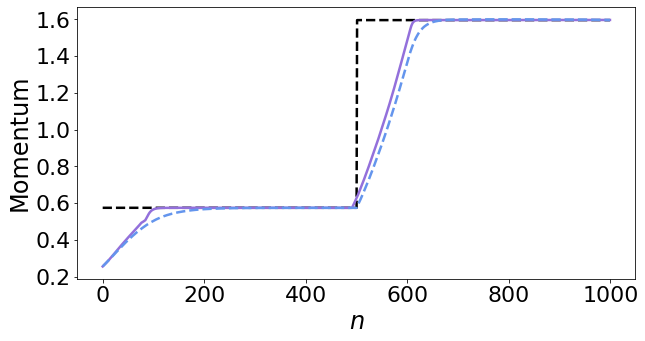

In [39]:

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

plt.plot(
    pk_kdv_opt_momentum_5,
    label=r"$Ours(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=vanilla_curve, 
    linestyle=vanilla_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)


# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, str(Nx)+'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, str(Nx)+'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()


# Save data

In [29]:
# import pandas as pd
# results_dict = {
#             'pk_kdv_opt_momentum_5': pk_kdv_opt_momentum_5,
#             'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
#             'momentum_ref':momentum_ref,
#             'pk_t_list_momentum_5': pk_t_list_momentum_5,
#             'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5
# }


# np.save(os.path.join(weights_path,'check_vanilla_'+str(Nx)+'.npy'), results_dict)
# results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
# results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
# results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_vanilla_'+str(Nx)+'.csv'), index=False)



# results_dict_list_pk_momentum_5 = [dict(result) for result in pk_results_momentum_5]
# results_dict_list_pk_momentum_5_df = pd.DataFrame(results_dict_list_pk_momentum_5)
# results_dict_list_pk_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_pk_'+str(Nx)+'.csv'), index=False)



In [36]:
# import pandas as pd
# import os
# file_path = os.path.join(weights_path, 'check_vanilla_' + str(Nx) + '.npy')
# results_dict = np.load(file_path, allow_pickle=True).item()

# pk_kdv_opt_momentum_5 = results_dict['pk_kdv_opt_momentum_5']
# # vanilla_kdv_opt_momentum_5 = results_dict['vanilla_kdv_opt_momentum_5']
# momentum_ref = results_dict['momentum_ref']
# pk_t_list_momentum_5 = results_dict['pk_t_list_momentum_5']
# # vanilla_t_list_momentum_5 = results_dict['vanilla_t_list_momentum_5']
# import pandas as pd
# results_dict = {
#             'pk_kdv_opt_momentum_5': pk_kdv_opt_momentum_5,
#             'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
#             'momentum_ref':momentum_ref,
#             'pk_t_list_momentum_5': pk_t_list_momentum_5,
#             'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5
# }


# np.save(os.path.join(weights_path,'check_vanilla_'+str(Nx)+'.npy'), results_dict)
# results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
# results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
# results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_vanilla_'+str(Nx)+'.csv'), index=False)

